Lawyer: Bryan Singer Not In Hawaii During Sexual Assault Claim
[0, 676, 520, 113, 16, 5213, 592, 1467, 1068, 3044]


<ipython-input-2-bd4958f96476>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.2658, accuracy_train: 0.4446, loss_valid: 1.3171, accuracy_valid: 0.4220, train_time: 1.9576sec
epoch: 2, loss_train: 1.2563, accuracy_train: 0.4698, loss_valid: 1.3164, accuracy_valid: 0.4550, train_time: 0.9630sec
epoch: 3, loss_train: 1.1515, accuracy_train: 0.5104, loss_valid: 1.1867, accuracy_valid: 0.5037, train_time: 1.3391sec
epoch: 4, loss_train: 1.1446, accuracy_train: 0.5141, loss_valid: 1.1851, accuracy_valid: 0.4970, train_time: 0.9604sec
epoch: 5, loss_train: 1.1075, accuracy_train: 0.5488, loss_valid: 1.1537, accuracy_valid: 0.5247, train_time: 0.9730sec
epoch: 6, loss_train: 1.3024, accuracy_train: 0.4659, loss_valid: 1.3750, accuracy_valid: 0.4400, train_time: 0.9642sec
epoch: 7, loss_train: 1.1278, accuracy_train: 0.5622, loss_valid: 1.2004, accuracy_valid: 0.5292, train_time: 0.9466sec
epoch: 8, loss_train: 0.9234, accuracy_train: 0.7015, loss_valid: 0.9774, accuracy_valid: 0.6694, train_time: 1.0725sec
epoch: 9, loss_train: 0.9158, accuracy_t

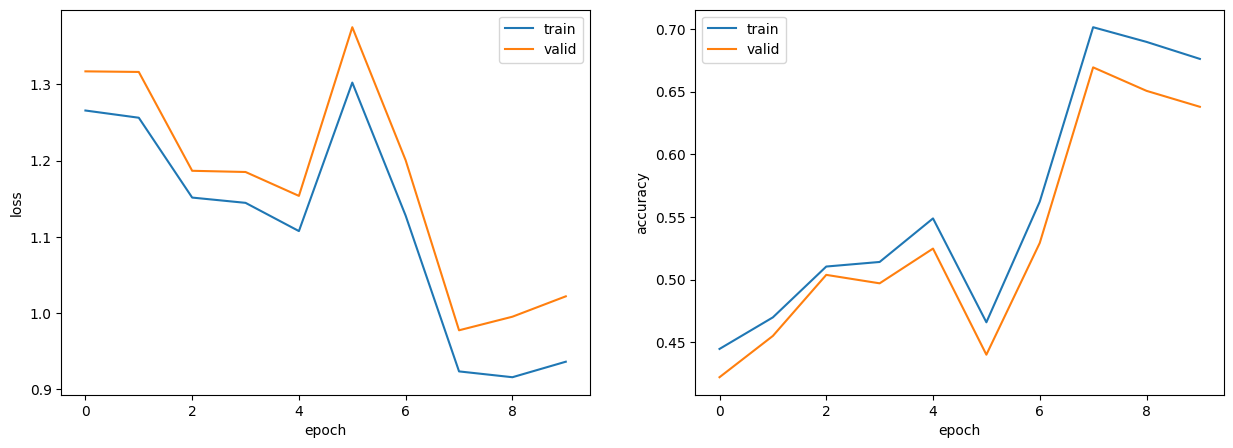

In [ ]:
"""
83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ
（Bの値は適当に選べ）．また，GPU上で学習を実行せよ
"""

from matplotlib import pyplot as plt
import numpy as np
from torch import optim
import time
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch
import pandas as pd
from collections import defaultdict
import string


# IDクラスを定義
class ID():
    def __init__(self, data):
        self.train_dict = defaultdict(int)  # 単語の頻度を記録する辞書
        self.id_list = []  # 単語とIDのペアを格納するリスト
        self.id_dict = dict()  # 単語からIDを取得するための辞書
        self.make_id(data)

    # データから単語IDを作成
    def make_id(self, data):
        for line in data:
            words = line.translate(table).split()  # 行から単語を抽出
            for word in words:
                self.train_dict[word] += 1  # 単語の頻度をカウント
        calc_dict = dict(self.train_dict)
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)  # 頻度でソート
        for i, (trg_word, freq) in enumerate(sort_list):
            if freq >= 2:  # 頻度が2以上の単語にIDを割り当て
                self.id_list.append((trg_word, i+1))
            else:
                self.id_list.append((trg_word, 0))  # 頻度が1以下の単語には0を割り当て
        self.id_dict = dict(self.id_list)

    # 行を単語IDのリストに変換
    def return_id(self, line):
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec


# 句読点をスペースに変換するテーブルを作成
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))

# ヘッダー名を定義
header_name = ['TITLE', 'CATEGORY']
train_file = "train.txt"
train_data = pd.read_csv(train_file, header=None, sep='\t', names=header_name)  # データの読み込み
w2id = ID(train_data['TITLE'])  # IDクラスのインスタンス作成
test_vec = w2id.return_id(train_data["TITLE"][10])  # 特定の行を単語IDに変換
print(train_data["TITLE"][10])
print(test_vec)

"""81 RNNによる予測"""

# RNNモデルの定義
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device):
        super().__init__()
        self.hid_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)  # 埋め込み層
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity="tanh", batch_first=True)  # RNN層
        self.fc = nn.Linear(hidden_size, output_size)  # 全結合層

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(1, self.batch_size, self.hid_size, device=device)  # 初期隠れ状態
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])  # 最後のタイムステップの出力を使用
        return out


# データセットクラスの定義
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }


# データの読み込み
train = pd.read_csv("train.txt", sep='\t')
valid = pd.read_csv("valid.txt", sep='\t')
test = pd.read_csv("test.txt", sep='\t')

# カテゴリを数値にマッピング
category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

# データセットの作成
dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)

"""82 確率的勾配降下法による学習"""

# 損失と精度の計算
def calc_loss_acc(model, dataset, device=None, criterion=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total


# モデルの学習
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None, collate_fn=None):
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')
    return {
        "train": log_train,
        "valid": log_valid
    }


# 学習ログの可視化
def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig("83.png")


"""83 ミニバッチ化・GPU上での学習"""

# シーケンスのパディングを行うクラス
class Padseq():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(
            batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}


# ハイパーパラメータの設定
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')

# モデルの初期化
model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

# 学習ログの可視化
visualize_logs(log)

# 精度の計算
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')
